# Business Problem
Customer churn directly impacts revenue and growth.
The business needs an early-warning system to identify customers who are likely to churn so that retention actions can be taken before they leave.

# Objective
Build a binary classification model using logistic regression to predict whether a customer will churn, and tune the decision threshold to balance missed churners against unnecessary retention outreach.

# What Success Looks Like
The model should prioritize recall for churners, ensuring that most customers who are likely to churn are identified, even if it means accepting some false positives.

# Data Overview
This is a telecom dataset from Codeveda

In [2]:
import pandas as pd

df1 = pd.read_csv("churn-bigml-80.csv")
df2 = pd.read_csv("churn-bigml-20.csv")


In [3]:
df1.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df2.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [5]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [6]:
df.shape

(3333, 20)

In [7]:
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [8]:
df.isin(['?', 'Unknown', 'None']).sum().sort_values(ascending=False)

State                     0
Account length            0
Customer service calls    0
Total intl charge         0
Total intl calls          0
Total intl minutes        0
Total night charge        0
Total night calls         0
Total night minutes       0
Total eve charge          0
Total eve calls           0
Total eve minutes         0
Total day charge          0
Total day calls           0
Total day minutes         0
Number vmail messages     0
Voice mail plan           0
International plan        0
Area code                 0
Churn                     0
dtype: int64

In [9]:
df.isna().sum().sort_values(ascending=False)

State                     0
Account length            0
Customer service calls    0
Total intl charge         0
Total intl calls          0
Total intl minutes        0
Total night charge        0
Total night calls         0
Total night minutes       0
Total eve charge          0
Total eve calls           0
Total eve minutes         0
Total day charge          0
Total day calls           0
Total day minutes         0
Number vmail messages     0
Voice mail plan           0
International plan        0
Area code                 0
Churn                     0
dtype: int64

In [10]:
df["Churn"] = df["Churn"].astype(int)


# Feature Engineering and Preprocessing

In [11]:
# Encode binary columns (map Yes/No → 1/0)
df["International plan"] = (
    df["International plan"]
    .str.strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
    .astype(int)
)

df["Voice mail plan"] = (
    df["Voice mail plan"]
    .str.strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
    .astype(int)
)


In [13]:
# Tenure-normalized usage
df["day_min_per_month"] = df["Total day minutes"] / (df["Account length"] + 1)
df["eve_min_per_month"] = df["Total eve minutes"] / (df["Account length"] + 1)
df["night_min_per_month"] = df["Total night minutes"] / (df["Account length"] + 1)
df["intl_min_per_month"] = df["Total intl minutes"] / (df["Account length"] + 1)

# Customer service pressure
df["high_support_calls"] = (df["Customer service calls"] >= 4).astype(int)

# Plan × usage interactions
df["intl_plan_usage"] = df["International plan"] * df["Total intl minutes"]
df["vmail_plan_usage"] = df["Voice mail plan"] * df["Number vmail messages"]

# Cost efficiency
df["day_cost_per_min"] = df["Total day charge"] / (df["Total day minutes"] + 1)
df["intl_cost_per_min"] = df["Total intl charge"] / (df["Total intl minutes"] + 1)


In [14]:
df.drop(
    columns=[              
        "Total day charge",          # replaced by cost_per_min
        "Total intl charge",
    ],
    inplace=True,
    errors="ignore"
)


In [15]:
# To check if state has any impact on churn
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['State'], df['Churn'])
chi2, p, dof, ex = chi2_contingency(contingency)
print('p-value:', p)


p-value: 0.002296221552011188


In [16]:
X = df.drop("Churn", axis=1)
y = df['Churn']

# Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [18]:
# Group 'state' by churn rate in training set
# Calculate churn rate per state in training data
state_churn_rate = pd.concat([X_train, y_train], axis=1).groupby('State')['Churn'].mean()

# Compute percentile thresholds (top 33%, bottom 33%)
high_threshold = state_churn_rate.quantile(0.66)
low_threshold = state_churn_rate.quantile(0.33)

# Define bins for high/medium/low churn states
# Adjust thresholds based on data distribution
def state_group(State):
    rate = state_churn_rate[State]
    if rate >= high_threshold:
        return 'high'
    elif rate <= low_threshold:
        return 'low'
    else:
        return 'medium'

X_train['state_group'] = X_train['State'].apply(state_group)
X_test['state_group'] = X_test['State'].apply(lambda s: state_group(s) if s in state_churn_rate else 'medium')

# One-Hot Encode the state groups
X_train = pd.get_dummies(X_train, columns=['state_group'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['state_group'], drop_first=True)

# Drop original 'state' column
X_train = X_train.drop('State', axis=1)
X_test = X_test.drop('State', axis=1)


In [19]:
# Convert boolean columns to int
bool_cols = ['state_group_low', 'state_group_medium']
for col in bool_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)


In [20]:
from sklearn.preprocessing import StandardScaler

# Create the scaler
scaler = StandardScaler()

# Fit on X_train only and transform X_train
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
# Count of each class
print(y_train.value_counts())

# Relative percentages
print(y_train.value_counts(normalize=True))


Churn
0    2280
1     386
Name: count, dtype: int64
Churn
0    0.855214
1    0.144786
Name: proportion, dtype: float64


# Model Selection

In [22]:
# We train the model on scaled data

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight={0: 1, 1: 3},
    max_iter=1000,
    solver="liblinear",
    random_state=42
)

model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 1, 1: 3}, max_iter=1000, random_state=42,
                   solver='liblinear')

## Model Evaluation
Evaluation focuses on:
- Recall for churn
- Precision trade-offs
- Confusion matrix analysis

Accuracy alone is not sufficient due to class imbalance.

In [23]:
# We evaluate properly
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[513  57]
 [ 26  71]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       570
           1       0.55      0.73      0.63        97

    accuracy                           0.88       667
   macro avg       0.75      0.82      0.78       667
weighted avg       0.89      0.88      0.88       667



## Decision Threshold Tuning

Instead of relying on a default 0.5 threshold, multiple thresholds are evaluated.

This allows the business to choose a balance between:
- Missing churn
- Operational workload from follow-ups

In [24]:
# The model already outputs probabilities, we were just throwing it away. Now we get probabilities instead of hard labels

y_proba = model.predict_proba(X_test_scaled)[:, 1]

In [25]:
for t in [0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Threshold 0.3
[[455 115]
 [ 10  87]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       570
           1       0.43      0.90      0.58        97

    accuracy                           0.81       667
   macro avg       0.70      0.85      0.73       667
weighted avg       0.90      0.81      0.84       667


Threshold 0.35
[[478  92]
 [ 14  83]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       570
           1       0.47      0.86      0.61        97

    accuracy                           0.84       667
   macro avg       0.72      0.85      0.76       667
weighted avg       0.90      0.84      0.86       667


Threshold 0.4
[[497  73]
 [ 20  77]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       570
           1       0.51      0.79      0.62        97

    accuracy                           0.86       667
   macro avg 

In [26]:
threshold = 0.4
y_pred_final = (y_proba >= threshold).astype(int)


In [27]:

coeffs = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coeffs

,feature,coefficient
21,intl_plan_usage,1.283106
5,Total day minutes,0.812440
20,high_support_calls,0.811656
4,Number vmail messages,0.343713
22,vmail_plan_usage,0.343713
24,intl_cost_per_min,0.281316
7,Total eve minutes,0.278441
19,intl_min_per_month,0.266387
9,Total eve charge,0.261735
18,night_min_per_month,0.152568


In [28]:
import numpy as np

coeffs["odds_ratio"] = coeffs["coefficient"].apply(lambda x: np.exp(x))
coeffs

,feature,coefficient,odds_ratio
21,intl_plan_usage,1.283106,3.607827
5,Total day minutes,0.812440,2.253400
20,high_support_calls,0.811656,2.251634
4,Number vmail messages,0.343713,1.410174
22,vmail_plan_usage,0.343713,1.410174
24,intl_cost_per_min,0.281316,1.324872
7,Total eve minutes,0.278441,1.321068
19,intl_min_per_month,0.266387,1.305240
9,Total eve charge,0.261735,1.299182
18,night_min_per_month,0.152568,1.164822


In [29]:
top_risk = coeffs.head(10)
top_protective = coeffs.tail(10)

In [30]:
top_risk

,feature,coefficient,odds_ratio
21,intl_plan_usage,1.283106,3.607827
5,Total day minutes,0.812440,2.253400
20,high_support_calls,0.811656,2.251634
4,Number vmail messages,0.343713,1.410174
22,vmail_plan_usage,0.343713,1.410174
24,intl_cost_per_min,0.281316,1.324872
7,Total eve minutes,0.278441,1.321068
19,intl_min_per_month,0.266387,1.305240
9,Total eve charge,0.261735,1.299182
18,night_min_per_month,0.152568,1.164822


In [31]:
top_protective

,feature,coefficient,odds_ratio
11,Total night calls,-0.004684,0.995326
1,Area code,-0.037379,0.963311
23,day_cost_per_min,-0.080077,0.923045
13,Total intl minutes,-0.119459,0.887401
14,Total intl calls,-0.189049,0.827746
26,state_group_medium,-0.271014,0.762606
25,state_group_low,-0.500115,0.606461
2,International plan,-0.527485,0.590087
17,eve_min_per_month,-0.610443,0.543110
3,Voice mail plan,-1.106879,0.330589


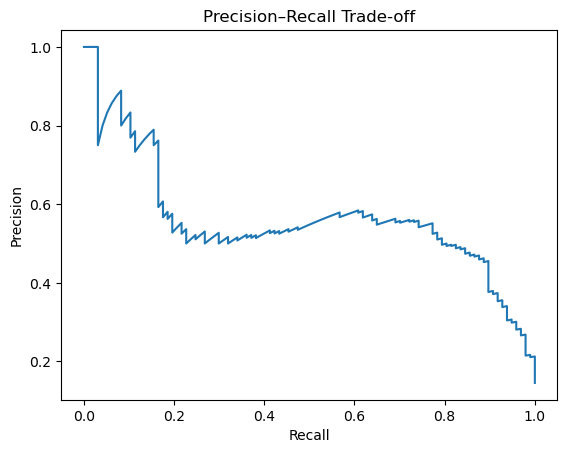

In [32]:
# Precision Recall curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off")
plt.show()

# Trade-Off
Lowering the classification threshold increases recall, allowing the model to catch more potential churners, but at the cost of lower precision and more false alarms.
Increasing the threshold improves precision but risks missing customers who actually churn, which is more costly to the business.

# Treshold Desicion
## Chosen Threshold
A threshold of 0.4 was selected as the operating point.
## Why
At this threshold, the model captures approximately 79% of churners while maintaining reasonable precision.
This provides a practical balance between retention coverage and operational cost.

# Recommendation
The model should be used as a churn-risk flagging system rather than a final decision tool.
Customers with predicted churn probability ≥ 0.4 should be prioritized for retention actions such as targeted offers, service quality checks, or proactive customer support.

# Conclusion
Logistic regression proved effective for predicting customer churn and offered clear interpretability.
By tuning the decision threshold, the model was aligned with business priorities, favoring recall to minimize lost customers.
This approach enables the business to act early on churn risk while transparently managing trade-offs.